In [3]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

# Chapter 1: Introduction

## 예제: 메시지 수신량 모델링

- 메시지 수신량의 패턴이 어느 순간 변한 것 같은데
    - 실제로 변했을까?
    - 언제, 얼만큼 변했을까?

In [6]:
dist = stats.beta
n_trials = 500
count_data = np.loadtxt("datasets/txtdata.csv")
n_count_data = len(count_data)

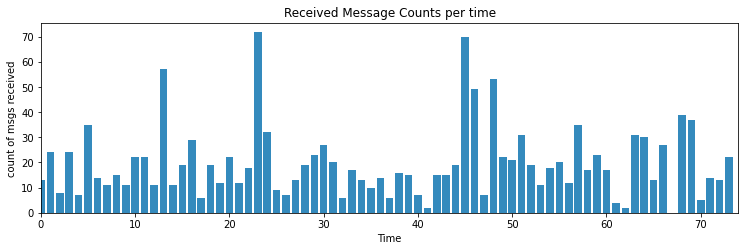

In [10]:
plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time")
plt.ylabel("count of msgs received")
plt.title("Received Message Counts per time")
plt.xlim(0, n_count_data);

### 문제 상황 모델링

$C_i$가 시간 $i$에서의 수신메시지 개수라고 할 때,

- Likelihood 가정
1. $C_i$가 Poisson 분포를 따른다고 가정.  
$\text{parameter}: \lambda$

2. $\tau$ 시점부터 분포가 달라진다고 가정.
$$ \lambda = 
\begin{cases}
\lambda_1 & \text{when }\; i < \tau \\
\lambda_2 & \text{when }\; i \geq \tau
\end{cases}
$$

- Prior 분포

1. $\lambda_i$를 잘 고르는 방법이 딱히 없으니 균등한 방법으로.  
$\lambda_i$가 Exponential 분포를 따른다고 가정.  
$\text{parent variable}: \alpha$  
$$ \lambda \sim \mathrm{Exp}(\alpha)$$

이 때 $\alpha$의 값은 Poisson 분포와 Exponential 분포의 관계를 통해  
$$ \mathbb{E}[\lambda \mid \alpha] = \frac{1}{\alpha} $$

2. $\tau$도 균등하게.
시간이 discrete한 숫자이니 discrete uniform 분포를 불러오면 된다.  
$$ \tau \sim \mathrm{DiscreteUniform}(0, \text{total_len_of_time})$$

**Exponential**

$$ f(x \mid \lambda) = \lambda \exp\left\{ -\lambda x \right\} $$

### 실제 MCMC 진행

In [13]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data-1)

In [18]:
lambda_1

lambda_1 ~ Exponential

In [17]:
lambda_2

lambda_2 ~ Exponential

In [19]:
tau

tau ~ DiscreteUniform

In [20]:
with model:
    idx = np.arange(n_count_data)
    # switch문
    lambda_ = pm.math.switch(idx < tau, lambda_1, lambda_2)

In [22]:
lambda_

Elemwise{switch,no_inplace}.0

In [21]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [23]:
observation

obs ~ Poisson

In [24]:
# MCMC 가동
with model:
    step = pm.Metropolis()
    trace = pm.sample(10_000, tune=5_000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [27]:
trace

<MultiTrace: 4 chains, 10000 iterations, 5 variables>

In [26]:
lambda_1_samples

array([17.78520234, 17.78520234, 17.78520234, ..., 17.21107458,
       17.52910865, 17.68184824])

In [30]:
lambda_1_samples.shape

(40000,)

### 시뮬레이션 완료 후 posterior 분포 확인

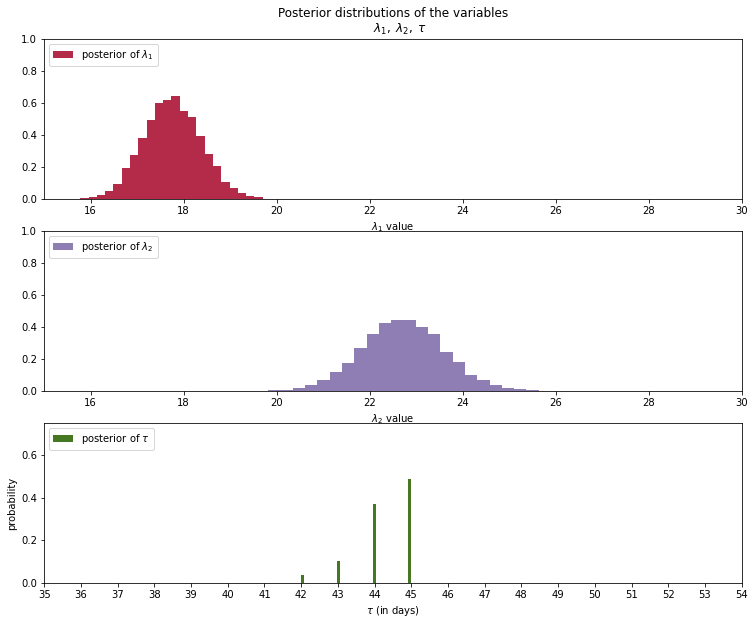

In [40]:
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", 
         weights=w, 
         rwidth=2.
        )
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### 시뮬레이션 결과 해석하기

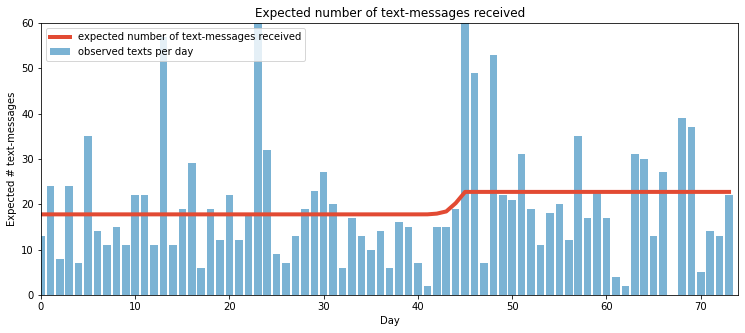

In [42]:
plt.figure(figsize=(12.5, 5))
# tau_samples, lambda_1_samples, lambda_2_samples
# 각각 posterior 분포로부터 N개씩 샘플링한 것(40_000개)
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    # ix: tau_samples에서 `day`보다 큰 경우에 대한 boolean array
    #     예를 들어 `day = 35`일 때, 
    #     35보다 작은 tau가 나온 케이스에서는 lambda_1을,
    #     35보다 큰 tau가 나온 케이스에서는 lambda_2을 뽑아내려는 목적이다.
    
    # E(C_t | lambda_1, lambda_2, tau) = lambda_1*(t < tau) + lambda_2*(t >= tau)
    # 총 N번의 시뮬레이션 중에 lambda_1가 p번, lambda_2가 N-p번 나왔다면
    # 그 lambda들의 횟수에 대한 weighted 평균을 구하면 된다.
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

### 연습문제

#### 1. `lambda_1_samples`, `lambda_2_samples`를 이용해서 $\lambda_1$, $\lambda_2$ 분포의 평균 구하기

In [46]:
lambda_1_mean = lambda_1_samples.mean()
lambda_2_mean = lambda_2_samples.mean()
print(lambda_1_mean, lambda_2_mean)

17.757725677888626 22.71496183374506


#### 2. 메시지 수신량의 증가율의 기댓값은?

- 참고로 `lambda_1_mean` / `lambda_2_mean`과는 다르다.

In [48]:
increase_rate = (lambda_1_samples / lambda_2_samples).mean()
increase_rate_wrong = lambda_1_mean / lambda_2_mean
print(increase_rate, increase_rate_wrong)

0.7829520495774598 0.7817633948875041


#### 3. $\tau$가 45보다 작다는 사실을 알고 있다고 가정했을 때, $\lambda_1$의 기댓값은?

- 새로운 정보가 들어왔을 때의 변화를 살펴보자

$$ \mathbb{E}[\lambda_1 \mid \tau < 45]$$ 

In [53]:
lambda_1_samples[tau_samples < 45].mean()

17.764632315984286